## 常用分布简介

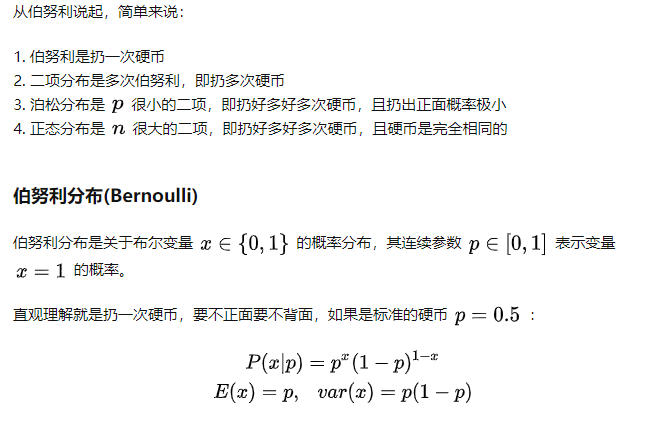

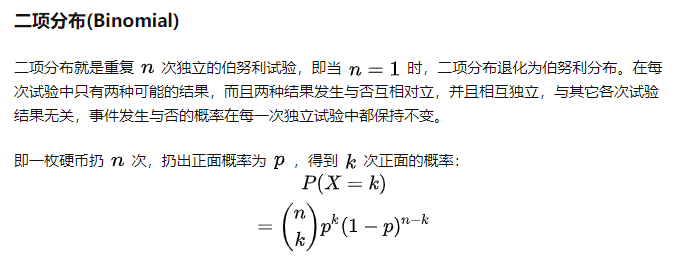

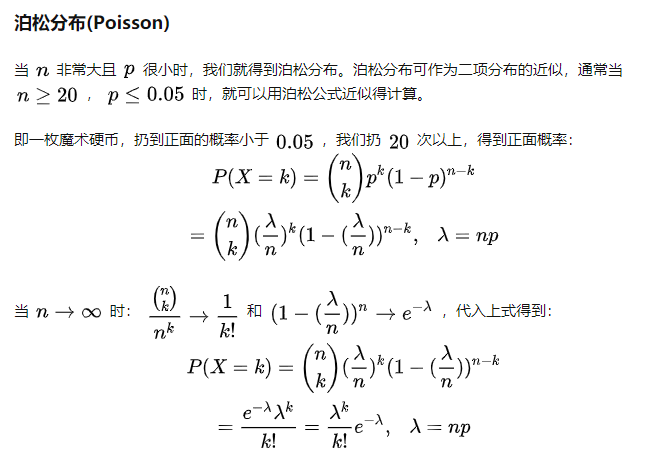

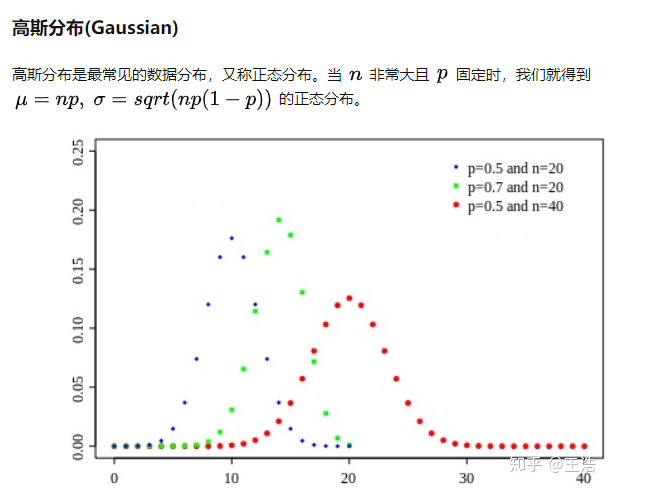

## 各分布之间的联系
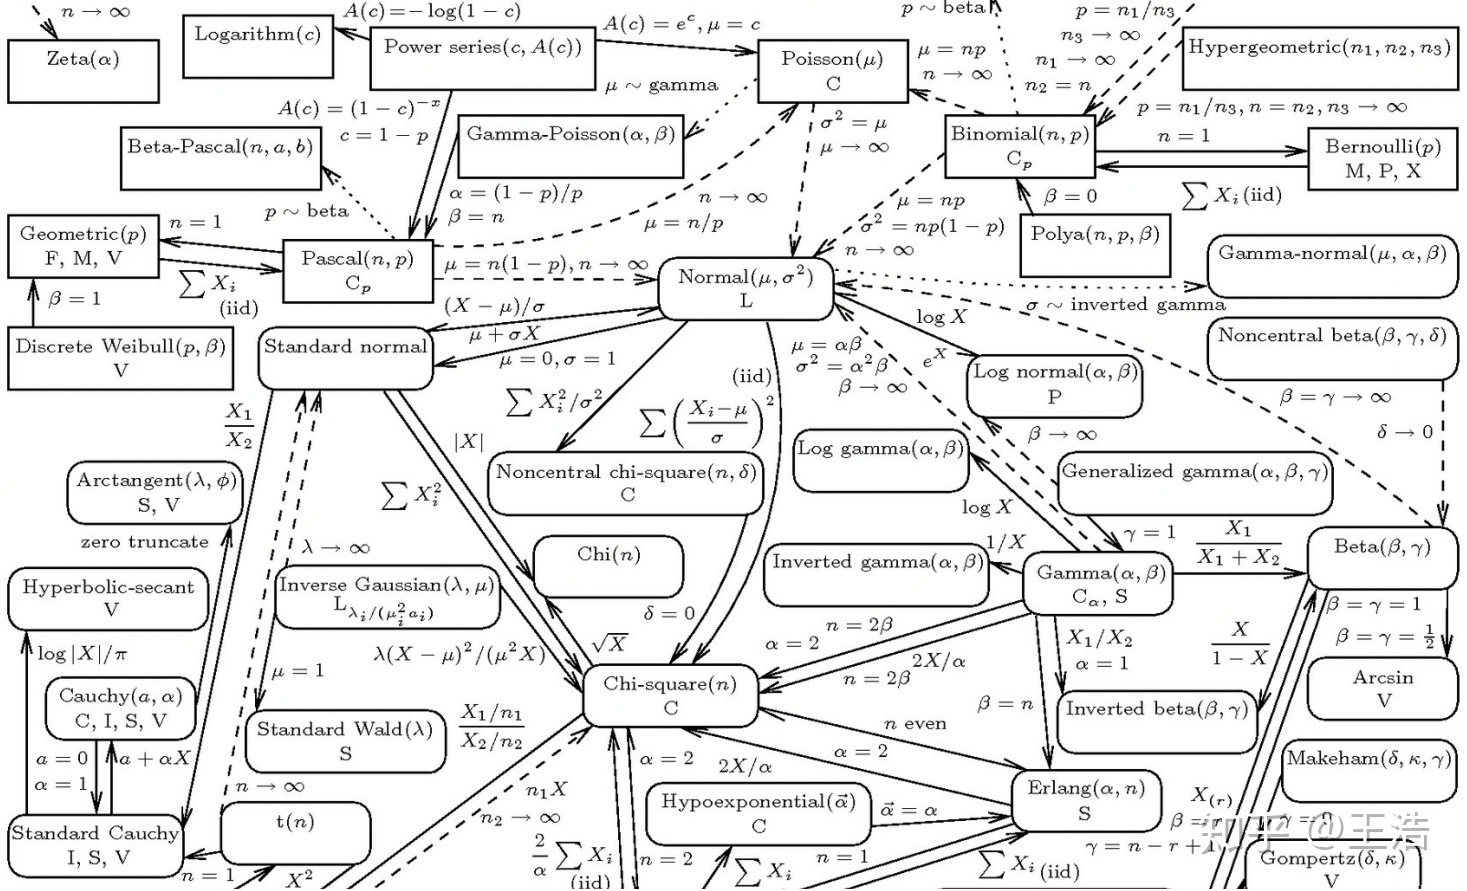

## 高斯判别分析（GDA）

Loading breast cancer dataset···
train_x.shape:  (398, 30)
test_x.shape:  (171, 30)
sigma.shape:  (398, 30, 30)
GDA Accuracy: 0.9649
LR Accuracy: 0.9766


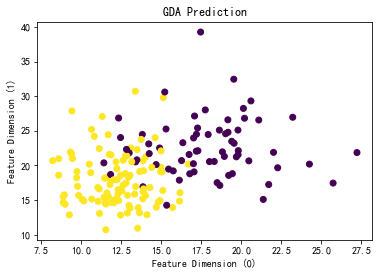

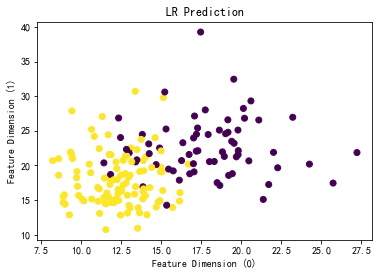

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score


def gaussian(x, mean, cov):
    """
    高斯分布概率密度函数
    :param x: 输入数据
    :param mean: 均值向量
    :param cov: 协方差矩阵
    :return: 样本x的后验概率
    """
    dim = cov.shape[0]

    # 防止cov行列式为零时无法计算，添加平滑项
    # 协方差矩阵的行列式
    # np.eye(): Return a 2-D array with ones on the diagonal and zeros elsewhere.
    cov_det = np.linalg.det(cov + np.eye(dim) * 0.001)
    # 协方差矩阵取逆
    cov_inv = np.linalg.inv(cov + np.eye(dim) * 0.001)

    # 样本x减去均值向量
    x_diff = (x - mean).reshape((1, dim))
    # 概率密度
    coef_numerator = 1.0
    coef_denominator = np.power(2 * np.pi, dim) * np.abs(cov_det)
    coef = coef_numerator / np.power(coef_denominator, 0.5)
    exp_ele = np.exp(- 0.5 * x_diff.dot(cov_inv).dot(x_diff.T))
    prob = coef * exp_ele[0][0]

    return prob


class GDA:
    def __init__(self, train_x, train_y):
        """
        高斯判别分析初始化
        :param train_x: 训练样本
        :param train_y: 训练样本标签
        """
        self.train_x = train_x
        self.train_y = train_y

        # 正负类样本个数
        self.n_positive = 0
        self.n_negative = 0
        # 真负类样本数组
        positive_x = []
        negative_x = []

        for x, y in zip(self.train_x, self.train_y):
            if y == 1:
                self.n_positive += 1
                positive_x.append(list(x))
            else:
                self.n_negative += 1
                negative_x.append(list(x))

        positive_x, negative_x = np.array(positive_x), np.array(negative_x)

        # 计算正负样本的二项分布的概率
        # rows 表示训练样本数组的第一个维度，即样本个数
        # cols 表示训练样本数组的第二个维度，即特征（属性）个数
        rows, cols = train_x.shape

        # # 正样本的比例
        # portion_positive = self.n_positive * 1.0 / rows
        # # 负样本的比例
        # portion_negative = 1 - portion_positive

        # 计算正负样本的高斯分布的均值向量 mu
        sum_positive_x = np.sum(positive_x, 0)
        sum_negative_x = np.sum(negative_x, 0)
        # 正负样本的均值向量
        self.mu_positive = sum_positive_x * 1.0 / self.n_positive
        self.mu_negative = sum_negative_x * 1.0 / self.n_negative

        # 计算正负样本的高斯分布的协方差矩阵 Sigma
        # 正负样本数组减去均值
        minus_mu_positive_x = positive_x - self.mu_positive
        minus_mu_negative_x = negative_x - self.mu_negative

        # 协方差矩阵
        self.sigma = []

        for pos_x in minus_mu_positive_x:
            reshaped_pos_x = pos_x.reshape(1, cols)
            sigma_ele = reshaped_pos_x.T.dot(reshaped_pos_x)
            self.sigma.append(sigma_ele)
        for neg_x in minus_mu_negative_x:
            reshaped_neg_x = neg_x.reshape(1, cols)
            sigma_ele = reshaped_neg_x.T.dot(reshaped_neg_x)
            self.sigma.append(sigma_ele)

        self.sigma = np.array(self.sigma)
        print("sigma.shape: ", self.sigma.shape)
        self.sigma = np.sum(self.sigma, 0)
        self.sigma = self.sigma / rows

        self.mu_positive = self.mu_positive.reshape(1, cols)
        self.mu_negative = self.mu_negative.reshape(1, cols)

    def predict(self, test_x):
        """
        进行预测
        :param test_x:
        :return: 正类或者负类标签（1 or 0）
        """
        pred_y = []
        for x in test_x:
            positive_prob = gaussian(x, self.mu_positive, self.sigma)
            negative_prob = gaussian(x, self.mu_negative, self.sigma)

            if positive_prob >= negative_prob:
                pred_y.append(1)
            else:
                pred_y.append(0)

        return pred_y


def main(lr=True, random_seed=2020, normalize_method='MinMax'):
    """
    :param lr: 是否与Logistic回归对比
    :param random_seed: 设置随机种子，保证每次测试结果相同，本质上是生成伪随机数，模型每次运行时，按同样的方式取相同的样本
    :param normalize_method: 规范化方法
    :return: 0
    """

    print("Loading breast cancer dataset···")
    # 加载乳腺癌数据集
    breast_cancer = load_breast_cancer()
    x = np.array(breast_cancer.data)
    y = np.array(breast_cancer.target)

    # step1:训练集和测试集划分
    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=random_seed)
    print("train_x.shape: ", train_x.shape)
    print("test_x.shape: ", test_x.shape)

    # step2:划分之后，再分别对训练集和测试集标准化，防止数据泄露
    if normalize_method == "MinMax":
        normed_train_x = MinMaxScaler().fit_transform(train_x)
        normed_test_x = MinMaxScaler().fit_transform(test_x)
    elif normalize_method == "Standard":
        normed_train_x = StandardScaler().fit_transform(train_x)
        normed_test_x = StandardScaler().fit_transform(test_x)
    else:
        normed_train_x = train_x
        normed_test_x = test_x

    # step3:GDA预测
    clf_gda = GDA(normed_train_x, train_y)
    test_pred = clf_gda.predict(normed_test_x)
    pred_acc = accuracy_score(test_y, test_pred)
    print("GDA Accuracy: %.4f" % pred_acc)

    # LR预测
    if lr:
        # Logistic回归结果
        clf_lr = LogisticRegression()
        clf_lr.fit(normed_train_x, train_y)
        test_pred = clf_lr.predict(normed_test_x)
        pred_acc = accuracy_score(test_y, test_pred)
        print("LR Accuracy: %.4f" % pred_acc)

    # 可视化
    # 防止绘图中文乱码
    mpl.rcParams['font.sans-serif'] = [u'simHei']
    mpl.rcParams['axes.unicode_minus'] = False

    plt.scatter(test_x[:, 0], test_x[:, 1], c=test_pred)
    plt.title("GDA Prediction")
    plt.xlabel('Feature Dimension (0)')
    plt.ylabel('Feature Dimension (1)')
    plt.show()

    # 数据可视化
    plt.scatter(test_x[:, 0], test_x[:, 1], c=test_pred)
    plt.title("LR Prediction")
    plt.xlabel('Feature Dimension (0)')
    plt.ylabel('Feature Dimension (1)')
    plt.show()


if __name__ == '__main__':
    main()


## GDA vs LR

- GDA的模型假设更强，故LR更具备鲁棒性，当数据不是特别服从高斯分布时，GDA效果略差于LR。
- 不同的 random_seed 两种模型差距比较大，建议多次运行取平均值！

Reference:
> 1. [高斯判别分析（GDA）Python代码](https://blog.csdn.net/qq_30091945/article/details/81508055)
> 2. [二项分布、泊松分布和正态分布的区别及联系?](https://www.zhihu.com/question/36214010)